In [1]:
def importa_documento(doc):
    import docx
    import os
    from collections import deque
    #from tqdm import tqdm
    documento = docx.Document(doc)

    parte_secao=[]
    titulo_secao =[]
    texto_secao =[]
    juncao_texto=[]
    secao_atual=[]
    i=0
    #print('Documento Encontrado\nIniciando análise de ',len(documento.paragraphs,"parágrafos"))
    for p in documento.paragraphs:#[0:510]:
        #tqdm(range(100))
        #i+=1
        #print("Analisando parágrafo <",i,"> ", end = "\r")
        if p.text in ('PARTE GERAL','PARTE I','PARTE II','PARTE III','PARTE IV','PARTE V'):
            parte_atual=p.text
        elif (p.style.name=='Heading 1') and (p.text != ''):
            texto_secao.append(' '.join(juncao_texto))
            juncao_texto=[]
            titulo_secao.append(secao_atual)
            parte_secao.append(parte_atual)
            secao_atual = p.text
        elif (p.style.name=='Heading 2') and (p.text != ''):
            juncao_texto.append('.'+p.text+'.')
        elif (p.style.name=='Heading 3') and (p.text != ''):
            juncao_texto.append('.'+p.text+'.')
        elif (p.style.name=='Heading 4') and (p.text != ''):
            juncao_texto.append('.'+p.text+'.')
        else:
            juncao_texto.append(p.text)

    titulo_secao[0]='CAPA'
    parte_secao = deque(parte_secao)
    parte_secao.rotate(1)
    parte_secao[0]='PRÉ-TEXTUAL'

    print('>>> O documento foi importado e dividido em '+str(len(parte_secao))+' seções.')
    #for k in range (len(titulo_secao)):
    #    print(str(parte_secao[k])+'\t\t'+str(titulo_secao[k]))
    
    return  texto_secao, parte_secao, titulo_secao

def limpa_texto(texto_secao):
    import re
    import pandas as pd
    import docx
    import unidecode
    #doc_compara = docx.Document()
    texto_clean=[]
    for t in texto_secao:
        t_bruto=t
        t = re.sub('1\.000','1000',t)
        t = re.sub('"x  x  x  x  xx"',"xxxxxx",t)
        t = re.sub('a\.m\.','ao mes.',t)
        t,cont = re.subn('\d+\/\d+\savos','um doze avos',t)
        t = re.sub('[D]\s\d.\d.[\dx]\.[\dx]\.[\dx]\.[\dx]+\.[\dx]+',' conta debito ',t)
        t = re.sub('[C]\s\d.\d.[\dx]\.[\dx]\.[\dx]\.[\dx]+\.[\dx]+',' conta credito ',t)
        t = re.sub('\d.\d.[\dx]\.[\dx]\.[\dx]\.[\dx]+\.[\dx]+',' conta ',t)
        t = re.sub('\d\.\d\.\d\.\d\.\d\d\.\d\.\d','Código',t)
        t = re.sub('ex\.','ex',t)
        t = re.sub('\.\s\.','.',t)
        t,cont = re.subn('\xa0',' ',t)
        t = re.sub(';','.',t)
        t = re.sub(':','',t)
        t = re.sub('Natureza da informação','\.Natureza da informação',t)
        t = re.sub('NE\s','NOTA EXPLICATIVA',t)
        t = re.sub('\(NE\)','NOTA EXPLICATIVA',t)
        t = re.sub('[123456789]\s[\-\.]\s','.',t)
        t = re.sub('\s[abcdefg]\.[\s\t]','.',t)
        t = re.sub('\d\.\d\s','.',t) #[\t\n]
        t = re.sub('^(i|ii|iii|iv|v|vi)\.','.',t)
        numeros_com_ponto = re.findall('nº\s(\d+\.\d+)',t)
        numero_com_ponto2 = re.findall('[\dx]+\.[\dx]+\.[\dx]+\.*[\dx]*\.*[\dx]*\.*[\dx]*\.*[\dx]*',t) #1.7.5.1.50.0.0
        numero_com_virgula = re.findall('[\d\.]+,\d\d',t)
        for n in numeros_com_ponto+numero_com_ponto2+numero_com_virgula:
            n1=re.sub('[\.,]','',n)
            n_sem_ponto=re.sub(r'/','',n1)
            t = re.sub(n,n_sem_ponto,t)    
        t = t.lower()
        t = re.sub('art[s]*\.','artigo ',t) #arts.
        t = re.sub('^\s','',t)
        t = re.sub('n[\.]*º','número ',t)
        t = re.sub('\.\s*\.','.',t)   
        t = re.sub('\t.','',t)
        t = re.sub('\s+',' ',t)
        t = re.sub('[()]','',t)
        t = re.sub('§',' parágrafo ',t)
        t = re.sub('“','',t)
        t = re.sub('R$','reais',t) #???
        t = re.sub('\.[\.]+','.',t)
        t = re.sub('[%s]' % re.escape('•…!"”ºª#$%&\'()*+,-–:<=>?@[\\]^_`{|}~'), '', t)
        t = re.sub('\/','',t)
        t = re.sub('maodeobra','mao de obra',t)
        t = re.sub('custobenefício','custo benefício',t)
        t = re.sub('fontedestinacao','fonte destinacao',t)
        t = re.sub('\.\s','.',t)
        #t = unidecode.unidecode(t)
        texto_clean.append(t)
        #p = doc_compara.add_paragraph()
        ##p.add_run('TEXTO_BRUTO\n\n').bold = True
        ##p.add_run(t_bruto)
        #p.add_run('TEXTO_CLEAN\n\n').bold = True
        #p.add_run(t)
    #doc_compara.save('Resultado Limpeza.docx')
    print('>>> A Limpeza do Texto foi Concluída')
    return texto_clean


def gera_resultados_limpeza(texto_clean):
    import docx
    from docx.enum.text import WD_ALIGN_PARAGRAPH as alinhamento
    doc_resultado = docx.Document()
    k=-1
    #import os
    #os.remove("!RESULTADOS1.docx")
    texto_sentencas = []

    for t in texto_clean:

        k = k+1
        p = doc_resultado.add_paragraph()
        p.add_run(parte_secao[k]+' - '+titulo_secao[k]+'\n').bold = True
        sentencas = t.strip()
        sentencas = sentencas.rstrip('.')
        sentencas = sentencas.split('.')
        i=0
        secao_sentencas = []
        s_adicional = ''
        for s in sentencas:        
            i=i+1
            if len(s.split(' '))<5:
                s_adicional = s_adicional+s+' '
            else:      
                p = doc_resultado.add_paragraph()
                p.add_run(str(i)+'. '+'_'*100+'\n').bold = True
                p.add_run(s_adicional+s+'\n')
                # => ZERAR s_adicional
                #p.alignment = alinhamento.LEFT
                secao_sentencas.append(s_adicional+s)
        texto_sentencas.append(secao_sentencas)
    doc_resultado.save('!_resultados_limpeza.docx')
    print('Arquivo docx para conferência da limpeza gerado')   

def gera_sentencas(texto_clean):
    # Essa função tem dimensao [tamanhosecao][sentecasnasecao]
    import docx
    from docx.enum.text import WD_ALIGN_PARAGRAPH as alinhamento
    doc_resultado = docx.Document()
    k=-1
    texto_sentencas = []
    for t in texto_clean:
        k = k+1
        p = doc_resultado.add_paragraph()
        p.add_run(parte_secao[k]+' - '+titulo_secao[k]+'\n').bold = True
        sentencas = t.strip()
        sentencas = sentencas.rstrip('.')
        sentencas = sentencas.split('.')
        i=0
        secao_sentencas = []
        s_adicional = ''
        for s in sentencas:        
            i=i+1
            if len(s.split(' '))<5: #Une sentenças pequenas (menos de 5 palavras)
                s_adicional = s_adicional+s+' '
            else:      
                p = doc_resultado.add_paragraph()
                p.add_run(str(i)+'. '+'_'*100+'\n').bold = True
                p.add_run(s_adicional+s+'\n')
                # => ZERAR s_adicional
                #p.alignment = alinhamento.LEFT
                secao_sentencas.append(s_adicional+s)
        texto_sentencas.append(secao_sentencas)
    doc_resultado.save('!_resultados_limpeza.docx')
    print('>>> A Identificação das setenças de cada seção foi concluída')
    texto_sentencas_secoes = []
    for t in texto_sentencas:
        uniao = '. '.join(t)
        texto_sentencas_secoes.append(uniao)
    #print(uniao,'\n')
    return texto_sentencas,texto_sentencas_secoes

def separa_silabas(texto_sentencas,metodo=1,comparacao_metodos=[]): 
    # OBTER O NUMERO DE PALAVRAS
    texto_palavras = []
    texto_palavras_longas =[]
    texto_silabas = []

    from hyphen import Hyphenator
    import pyphen
    h = Hyphenator('pt_BR')
    dic = pyphen.Pyphen(lang='pt_BR')
    n_palavras_longas = []
    
    i=-1
    for t in texto_sentencas:
        i=i+1
        j=-1
        silabas_sentenca = []
        silabas_sentenca2 = []
        palavras_longas_sentenca =[]
        palavras_longas_sentenca2 =[]
        for s in t:
            j=j+1
            #print('secao: ',i,' sentenca :',j)
            words = s.split(' ')     
            silabas = []
            silabas2 = []
            palavras_longas = []
            palavras_longas2 = []
            for w in words:
                w_silaba = h.syllables(w)
                w_silaba2 = dic.inserted(w).split('-')
                if not w_silaba: w_silaba = [str(w)] #se for monossílaba mantém a palavra
                
                #COMPARACAO
                if w_silaba==w_silaba2:
                    pass
                else:
                    comparacao_metodos.append(['-'.join(w_silaba),'-'.join(w_silaba2)])        
                
                if metodo==2:
                    w_silaba = w_silaba2
                silabas.append(w_silaba)  
                if len(w_silaba)>3:
                    palavras_longas.append(w)
            silabas = sum(list(filter(lambda x: x, silabas)),[])
            silabas_sentenca.append(silabas)
            palavras_longas_sentenca.append(palavras_longas)
            #print(silabas)
        texto_silabas.append(silabas_sentenca)
        texto_palavras_longas.append(palavras_longas_sentenca)
    print('>>> A separação de sí-la-bas foi concluída')   
    return texto_silabas, texto_palavras_longas, comparacao_metodos

def medidas_sentencas(texto_sentencas,texto_silabas):
    import re
    n_sentencas = []
    n_palavras =  []
    n_letras = []
    for t in texto_sentencas:
        n_sentencas.append(len(t))
        n_ps = [] #nº palavras/sentença
        n_ls = [] #nº letras/sentença
        for s in t:
            n_ps.append(len(s.split(' ')))
            n_ls.append(len(re.sub(' ','',s)))
            #print(len(s.split(' ')))
        n_palavras.append(n_ps)
        n_letras.append(n_ls)
        
    n_silabas = []
    for t in texto_silabas:
        n_ss  = [] #nº silabas/sentença
        for s in t:
            #print(len(s))
            n_ss.append(len(s))
        n_silabas.append(n_ss)
    
    n_palavras_longas =[]
    for t in texto_palavras_longas:
        n_pl = []
        for s in t:
            n_pl.append(len(s))
        n_palavras_longas.append(n_pl)
    print('>>> Métricas das sentenças obtidas')   
    return n_sentencas,n_palavras, n_letras, n_silabas, n_palavras_longas

def totaliza(lista):
    total = []
    for i in lista: total.append(sum(i))
    return total

def divide_lista(L1,L2):
    L = [round(i/j,2) for i, j in zip(L1,L2)]
    return L

def gera_saidas(parte_secao,titulo_secao,texto_secao,texto_clean,n_sentencas,n_palavras,
                n_letras, n_silabas, n_palavras_longas,
                n_sentencas_textacy,n_silabas_textacy,n_caracteres_textacy,n_caracteres_por_palavra_textacy,    
                indice_fk,indice_fe,indice_gf,indice_cl,indice_smog,
                gera_excel=True):
    import pandas as pd
    df_analise = pd.DataFrame()
    df_analise['Parte'] = parte_secao #OK
    df_analise['Titulo']= titulo_secao #OK
    df_analise['Texto Bruto'] = texto_secao #OK
    df_analise['Texto Clean'] = texto_clean #OK
    df_analise['Nº Sentenças'] = n_sentencas #OK
    df_analise['Nº Sentenças Textacy'] = n_sentencas_textacy #OK
    df_analise['Nº Palavras'] = n_palavras #OK
    df_analise['Total Nº Palavras'] = totaliza(n_palavras) #OK
    df_analise['Nº Palavras Longas'] = n_palavras_longas #OK
    df_analise['Total Nº Palavras Longas'] = totaliza(n_palavras_longas)
    df_analise['Nº Sílabas'] = n_silabas #OK
    df_analise['Total Nº Sílabas'] = totaliza(n_silabas) #OK
    df_analise['Nº Letras'] = n_letras  #OK
    df_analise['Total Nº Letras'] = totaliza(n_letras)  #OK
    df_analise['Palavras por Sentença'] = divide_lista(totaliza(n_palavras),n_sentencas)
    df_analise['Sílabas por Palavra'] = divide_lista(totaliza(n_silabas),totaliza(n_palavras))
    df_analise['Letras por Palavra'] = divide_lista(totaliza(n_letras),totaliza(n_palavras))
    
    df_analise['Nº Sentenças Textacy'] = n_sentencas_textacy
    df_analise['Nº Sílabas Textacy'] = n_silabas_textacy
    df_analise['Nº Caracteres Textacy'] = n_caracteres_textacy
    df_analise['Nº Caracteres por Palavra Textacy'] = n_caracteres_por_palavra_textacy
    
    #n_sentencas_textacy,n_silabas_textacy,n_caracteres_textacy,n_caracteres_por_palavra_textacy    
    #indice_fk,indice_fe,indice_gf,indice_cl,indice_smog  

    df_analise['Flesch-Kincaid Grade Level Textacy'] = indice_fk
    df_analise['Flesch Reading Ease Textacy'] = indice_fe
    df_analise['Gunning Fog Textacy'] = indice_gf
    df_analise['Coleman Liau Textacy'] = indice_cl
    df_analise['SMOG index Textacy'] = indice_smog
    
    #df_analise['null'] = [0]*len(parte_secao)
    if gera_excel == True:
         df_analise.to_excel("Resultados Análise.xlsx") 
    return df_analise

def medidas_textacy(texto_sentencas_secoes):
    import spacy
    from spacy.language import Language    
    import textacy
    import statistics
    from textacy import text_stats

    @Language.component('mycustom_boundary')
    def mycustom_boundary(docx):
        for token in docx[:-1]:
            if token.text == '.':
                docx[token.i+1].is_sent_start = True
        return docx

    nlp = spacy.load("pt_core_news_sm",disable=["lemmatizer", "ner"])
    config = {"punct_chars": ['.','. ',' .']}
    #nlp.add_pipe("sentencizer", config=config)
    nlp.add_pipe('mycustom_boundary',before='parser')
    nlp.remove_pipe('parser')
    #print(nlp.pipe_names,'\n')

    n_sentencas_textacy =[]
    n_silabas_textacy = []
    n_caracteres_textacy = []
    n_silabas_textacy = []
    n_caracteres_por_palavra_textacy = []
    i=0
    nlp.max_length = 1934003
    
    for d in texto_sentencas_secoes:
        i+=1
        print("Analisando Seção <",i,">", end = "\r")
        mydoc = nlp(d)
        n_sentencas_textacy.append(text_stats.n_sents(mydoc))
        n_silabas_textacy.append(text_stats.n_syllables(mydoc))
        n_caracteres_textacy.append(text_stats.n_chars(mydoc))
        n_caracteres_por_palavra_textacy.append(statistics.mean(list(text_stats.n_chars_per_word(mydoc))))
    return (n_sentencas_textacy,n_silabas_textacy,n_caracteres_textacy,n_caracteres_por_palavra_textacy)

def readability_textacy(texto_sentencas_secoes):

    import spacy
    from spacy.language import Language    
    import textacy
    from textacy import text_stats

    @Language.component('mycustom_boundary')
    def mycustom_boundary(docx):
        for token in docx[:-1]:
            if token.text == '.':
                docx[token.i+1].is_sent_start = True
        return docx

    nlp = spacy.load("pt_core_news_sm",disable=["lemmatizer", "ner"])
    config = {"punct_chars": ['.','. ',' .']}
    nlp.add_pipe('mycustom_boundary',before='parser')
    nlp.remove_pipe('parser')  
    nlp.max_length = 1934003
    
    indice_fk=[]
    indice_fe=[]
    indice_gf =[]
    indice_cl =[]
    indice_smog=[]
    
    #doc_t=textacy.make_spacy_doc(t,lang='pt_core_news_sm')
    i=0
    for d in texto_sentencas_secoes:
        i+=1
        print("Analisando Seção <",i,">", end = "\r")
        mydoc = nlp(d)
        indice_fk.append(text_stats.flesch_kincaid_grade_level(mydoc))
        indice_fe.append(text_stats.flesch_reading_ease(mydoc))
        indice_gf.append(text_stats.gunning_fog_index(mydoc))
        indice_cl.append(text_stats.coleman_liau_index(mydoc))
        indice_smog.append(text_stats.smog_index(mydoc))
    return (indice_fk,indice_fe,indice_gf,indice_cl,indice_smog)

print('>>> Importação das Bibliotecas conlcuídas')    

>>> Importação das Bibliotecas conlcuídas


In [2]:
texto_secao, parte_secao, titulo_secao = importa_documento("MCASP9ed.docx")

>>> O documento foi importado e dividido em 56 seções.


In [3]:
texto_clean = limpa_texto(texto_secao)
#gera_resultados_limpeza(texto_clean)

>>> A Limpeza do Texto foi Concluída


In [4]:
texto_sentencas,texto_sentencas_secoes = gera_sentencas(texto_clean)

>>> A Identificação das setenças de cada seção foi concluída


In [5]:
texto_silabas, texto_palavras_longas, comparacao_metodos = separa_silabas(texto_sentencas,metodo=2)
#for c in comparacao_metodos: print(repr(c[0]),'\t\t\t',c[1])

>>> A separação de sí-la-bas foi concluída


In [6]:
n_sentencas,n_palavras, n_letras, n_silabas, n_palavras_longas = medidas_sentencas(texto_sentencas,texto_silabas)

>>> Métricas das sentenças obtidas


In [7]:
n_sentencas_textacy,n_silabas_textacy,n_caracteres_textacy, n_caracteres_por_palavra_textacy = medidas_textacy(texto_sentencas_secoes)

In [8]:
indice_fk,indice_fe,indice_gf,indice_cl,indice_smog = readability_textacy(texto_sentencas_secoes)

In [9]:
df_analise = gera_saidas(parte_secao,titulo_secao,texto_secao,texto_clean,n_sentencas,n_palavras,
                n_letras, n_silabas, n_palavras_longas,
                n_sentencas_textacy,n_silabas_textacy,n_caracteres_textacy,n_caracteres_por_palavra_textacy,    
                indice_fk,indice_fe,indice_gf,indice_cl,indice_smog,
                gera_excel=True)

In [10]:
# CALCULO MANUAL DO INDICE
# FAIXA DE TRABALHO
# ANOVA PRA TESTAR DIFERENÇA ENTE FAIXAS

def manual_readbility(n_sentencas,n_palavras,n_letras, n_silabas):
    sil_por_pal = [a/b for a,b in zip(totaliza(n_silabas),totaliza(n_palavras))]
    pal_por_sen = [a/b for a,b in zip(totaliza(n_palavras),n_sentencas)]
    reading_score = [round(248.835-84.6*a-1.015*b,2) for a,b in zip(sil_por_pal,pal_por_sen)]
    def faixa(r):
        f=[]
        for s in r:
            if s>= 75:
                f.append('Muito Fácil')
            elif s>= 50 :
                f.append('Fácil')
            elif s>= 25:
                f.append('Difícil')
            else:
                f.append('Muito Difícil')
        return(f)
    reading_score_faixa = faixa(reading_score)
    #http://www.nilc.icmc.usp.br/nilc/download/Reltec28.pdf
    #http://www.ufrgs.br/textecc/acessibilidade/files/%C3%8Dndices-de-Leiturabilidade.pdf 
    return(reading_score,reading_score_faixa)

reading_score,reading_score_faixa = manual_readbility(n_sentencas,n_palavras,n_letras, n_silabas)

print(reading_score)
print(reading_score_faixa)

[9.35, 12.13, 2.32, 12.89, 10.0, 4.24, -32.29, 15.63, 6.16, -14.62, -58.05, -273.86, 33.28, 28.16, 6.01, -36.13, 9.73, -0.1, 2.72, 6.26, -8.03, -9.21, -27.77, 9.25, -60.6, -27.48, 16.66, -18.74, 12.56, -1.39, -34.25, 15.4, 29.44, -13.13, 1.68, -0.7, 20.2, -8.69, 15.62, -76.76, -0.81, 7.9, -5.48, 23.3, 30.48, -14.92, -39.39, -5.47, 5.8, -5.15, -30.36, -14.4, 12.71, -47.85, 1.23, -34.63]
['Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Difícil', 'Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil', 'Muito Difícil',

In [ ]:
df_analise
a = df_analise[["Titulo","Nº Sentenças","Nº Sentenças Textacy","Total Nº Sílabas"]]
b = a[a["Nº Sentenças"]!=a["Nº Sentenças Textacy"]]
#b.head()

In [13]:
df_analise.head(5)

,Parte,Titulo,Texto Bruto,Texto Clean,Nº Sentenças,Nº Sentenças Textacy,Nº Palavras,Total Nº Palavras,Nº Palavras Longas,Total Nº Palavras Longas,...,Sílabas por Palavra,Letras por Palavra,Nº Sílabas Textacy,Nº Caracteres Textacy,Nº Caracteres por Palavra Textacy,Flesch-Kincaid Grade Level Textacy,Flesch Reading Ease Textacy,Gunning Fog Textacy,Coleman Liau Textacy,SMOG index Textacy
0,PRÉ-TEXTUAL,CAPA,\n MINISTÉRIO DA ECONOMIA SECRETARIA DO TESOUR...,ministério da economia secretaria do tesouro ...,45,45,"[462, 117, 60, 40, 68, 14, 34, 58, 22, 23, 22,...",2471,"[82, 20, 4, 8, 8, 4, 10, 5, 7, 3, 6, 11, 11, 7...",434,...,2.17,5.15,5310,12721,5.269677,31.287423,8.293925,37.116436,14.632567,29.308192
1,PARTE GERAL,CONTEXTUALIZAÇÃO,A ciência contábil no Brasil vem passando por...,a ciência contábil no brasil vem passando por ...,13,13,"[16, 26, 44, 10, 28, 66, 14, 32, 50, 55, 39, 2...",472,"[4, 4, 8, 3, 8, 11, 4, 7, 11, 11, 11, 5, 10]",97,...,2.36,5.83,1111,2752,5.880342,26.462393,11.460385,31.152137,17.952861,25.311130
2,PARTE GERAL,PLANO DE CONTAS APLICADO AO SETOR PÚBLICO (PCASP),O PCASP representa uma das maiores conquistas...,o pcasp representa uma das maiores conquistas ...,5,5,"[13, 69, 55, 28, 28]",193,"[2, 20, 15, 7, 8]",52,...,2.45,6.02,472,1162,6.052083,28.394333,1.884000,33.068333,19.014042,26.683356
3,PARTE GERAL,"ASPECTOS ORÇAMENTÁRIO, PATRIMONIAL E FISCAL DA...",O objetivo principal da maioria das entidades...,o objetivo principal da maioria das entidades ...,36,36,"[26, 17, 25, 22, 21, 18, 33, 8, 27, 29, 28, 10...",910,"[5, 4, 8, 6, 7, 8, 10, 2, 4, 5, 7, 2, 3, 6, 2,...",224,...,2.49,6.01,2261,5469,6.016502,23.608215,12.776547,28.405831,18.403556,22.548703
4,PARTE GERAL,IMPLANTAÇÃO DAS INOVAÇÕES NA CONTABILIDADE APL...,As inovações trazidas pelos processos de padr...,as inovações trazidas pelos processos de padro...,5,5,"[68, 80, 35, 34, 24]",241,"[10, 10, 9, 10, 9]",48,...,2.24,5.53,532,1333,5.745690,29.564621,7.742448,34.249655,17.345338,27.500509


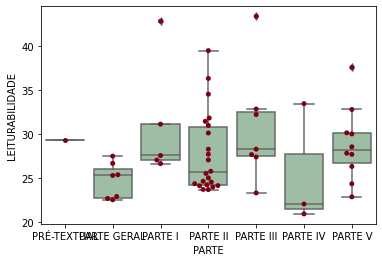

<Figure size 720x72 with 0 Axes>

In [36]:
dados = df_analise[['Parte','SMOG index Textacy']]
dados = dados.drop(index=11)
dados.columns = ['PARTE', 'LEITURABILIDADE']
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
ax = sns.boxplot(x='PARTE', y='LEITURABILIDADE', data=dados, color='#99c2a2')
ax = sns.swarmplot(x="PARTE", y="LEITURABILIDADE", data=dados, color='#7d0013')
plt.figure(figsize=(10,1))
plt.show()


In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import  ols
mod = ols('LEITURABILIDADE ~ PARTE',data=dados).fit()
anova_table_table = sm.stats.anova_lm(mod,typ=2)
print(anova_table_table)

               sum_sq    df         F   PR(>F)
PARTE      200.491172   6.0  1.396978  0.23528
Residual  1148.142154  48.0       NaN      NaN


In [39]:
df_analise['Flesch-Kincaid Grade Level Textacy'] = indice_fk
df_analise['Flesch Reading Ease Textacy'] = indice_fe
df_analise['Gunning Fog Textacy'] = indice_gf
df_analise['Coleman Liau Textacy'] = indice_cl
df_analise['SMOG index Textacy'] = indice_smog